# Sicherman Dice

*Note: This notebook takes the form of a conversation between two problem solvers. One speaks in* **bold**, *the other in* plain. *Also note, for those who are not native speakers of English: "dice" is the plural form; "die" is the singular.*

Huh. <a href="http://wordplay.blogs.nytimes.com/2014/06/16/dice-3/">This</a> is interesting.  You know how in many games, such as craps or Monopoly, you roll two regular dice and add them up. Only the sum matters, not what either of the individual dice shows.

**Right.**

And some of those sums, like 8, can be made multiple ways, while 2 and 12 can only be made one way. 

**Yeah. 8 can be made 5 ways, so it has a 5/36 probability of occurring.**

The interesting thing is that people have been playing dice games for 7,000 years. But it wasn't until 1977 that <a href="http://userpages.monmouth.com/~colonel/">Colonel George Sicherman</a> asked whether is is possible to have a pair of dice that are not regular dice&mdash;that is, they don't have (1, 2, 3, 4, 5, 6) on the six sides&mdash;but have the same distribution of sums as a regular pair&mdash;so the pair of dice would also have to have 5 ways of making 8, but it could be different ways; maybe 7+1 could be one way. Sicherman assumes that each side bears a positive integer.

**And what did he find?**

Wouldn't it be more fun to figure it out for ourselves?

**OK!**

How could we proceed?

**When in doubt, [use brute force](http://quotes.lifehack.org/quote/ken-thompson/when-in-doubt-use-brute-force/): we can write a program to enumerate the possibilities:**


- **Generate all dice that could possibly be part of a solution, such as (1, 2, 2, 4, 8, 9).**
- **Consider all pairs of these dice, such as ((1, 3, 4, 4, 5, 8), (1, 2, 2, 3, 3, 4))**
- **See if we find any pairs that are not the regular pair, but do have the same distribution of sums as the regular pair.**


That's great.  I can code up your description almost verbatim. I'll also keep track of our TO DO list:

In [1]:
def sicherman():
    """The set of pairs of 6-sided dice that have the same
    distribution of sums as a regular pair of dice."""
    return {pair for pair in pairs(all_dice())
            if pair != regular_pair
            and sums(pair) == regular_sums}

# TODO: pairs, all_dice, regular_pair, sums, regular_sums

**Looks good to me.**

Now we can tick off the items in the TO DO list. The function `pairs` is first, and it is easy:

In [2]:
def pairs(collection): 
    "Return all pairs (A, B) from collection where A <= B."
    return [(A, B) for A in collection for B in collection if A <= B]

# TODO: all_dice, regular_pair, sums, regular_sums

**That's good. We could have used the library function `itertools.combinations_with_replacement`, but let's just leave it as is. We should test to make sure it works:**

In [3]:
pairs(['A', 'B', 'C'])

[('A', 'A'), ('A', 'B'), ('A', 'C'), ('B', 'B'), ('B', 'C'), ('C', 'C')]

# TO DO: `sums(pair)`


Now for `sums`: we need some way to represent all the 36 possible sums from a pair of dice.  We want a representation that will be the same for two different pairs if all 36 sums are the same, but where the order or composition of the sums doesn't matter. 

**So we want a set of the sums?**

Well, it can't be a set, because we need to know that 8 can be made 5 ways, not just that 8 is a member of the set. The technical term for a collection where order doesn't matter but where you can have repeated elements is a **bag**, or sometimes called a [**multiset**](https://en.wikipedia.org/wiki/Multiset). For example, the regular pair of dice makes two 11s with 5+6 and 6+5, and another pair could make two 11s with 7+4 and 3+8.  Can you think of a representation that will do that?

**Well the easiest is just a sorted list or tuple&mdash;if we don't want order to matter, sorting takes care of that.  Another choice would be a dictionary of {sum: count} entries, like {2: 1, 3: 2, ... 11: 2, 12: 1}. There is even a library class, `collections.Counter`, that does exactly that.**

How do we choose between the two representations?

**I don't think it matters much.  Since there are only 36 entries, I think the sorted list will be simpler, and probably more efficient.  For 100-sided dice I'd probably go with the Counter.**

OK, here's some code implementing `sums` as a sorted list, and definitions for regular die pair, and sums.
By the way, I could have used `range(1, 7)` to define a regular die, but `range` is zero-based, and regular dice are one-based, so I defined the function `ints` instead.

In [4]:
def sums(pair):
    "All possible sums of a side from one die plus a side from the other."
    (A, B) = pair
    return Bag(a + b for a in A for b in B)

Bag = sorted # Implement a bag as a sorted list

def ints(start, end): 
    "A tuple of the integers from start to end, inclusive."
    return tuple(range(start, end + 1))

regular_die  = ints(1, 6)
regular_pair = (regular_die, regular_die)
regular_sums = sums(regular_pair)

# TODO: all_dice

Let's check the `regular_sums`:

In [5]:
len(regular_sums)

36

In [6]:
print(regular_sums)

[2, 3, 3, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 11, 11, 12]


**And we can see what that would look like to a `Counter`:**

In [7]:
from collections import Counter

Counter(regular_sums)

Counter({2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 5, 9: 4, 10: 3, 11: 2, 12: 1})

**Looks good! Now only one more thing on our TODO list:**

# TO DO: `all_dice()`


`all_dice` should generate all possible dice, where by "possible" I mean the dice that could feasibly be part of a pair that is a solution to the Sicherman problem. Do we know how many dice that will be? Is it a large enough number that efficiency will be a problem?

**Let's see.  A die has six sides each. If each side can be a number from, say, 1 to 10, that's 10<sup>6</sup> or a million possible dice; a million is a small number for a computer.**

True, a million is a relatively small number for `all_dice()`, but how many `pairs(all_dice())` will there be?

**Ah.  A million squared is a trillion.  That's a large number even for a computer. Just counting to a trillion takes hours in Python; checking a trillion pairs will take days.**

So we need to get rid of most of the dice. What about permutations?

**Good point.  If I have the die (1, 2, 3, 4, 5, 6), then I don't need the 6! = 720 different permutations of this die&mdash; that is, dice like (2, 4, 6, 1, 3, 5).
Each die should be a bag (I learned a new word!) of sides.  So we've already eliminated 719/720 = 99.9% of the work.**

One other thing bothers me ... how do you know that the sides can range from 1 to 10?  Are you sure that 11 can't be part of a solution? Or 12?

**Every side on every die must be a positive integer, right?**

Right. No zeroes, no negative numbers, no fractions.

**Then I know for sure that 12 can't be on any die, because when you add 12 to whatever is on the other die, you would get at least 13, and 13 is not allowed in the regular distribution of sums.**

Good. How about 11?

**We can't have a sum that is bigger than 12.  So if one die had an 11, the other would have to have all 1s.  That wouldn't work, because then we'd have six 12s, but we only want one. So 10 is the biggest allowable number on a die.**

What else can we say about the biggest number on a die?

**There's one 12 in the sums.  But there are several ways to make a 12: 6+6 or 7+5 or 8+4, and so on.  So I can't say for sure what the biggest number on any one die will be.  But I can say that whatever the biggest number on a die is, it will be involved in summing to 12, so there can be only one of them, because we only want to make one 12.**

What about the smallest number on a die?

**Well, there's only one 2 allowed in the sums.  The only way to sum to 2 is 1+1: a 1 from each of the dice in the pair.  If a die had no 1s, we wouldn't get a 2; if a die had more than one 1, we would get too many 2s.  So every die has to have exactly one 1.**

Good.  So each die has exactly one 1, and exactly one of whatever the biggest number is, something in the range up to 10.  Here's a picture of the six sides of any one die:

<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">&nbsp;1&nbsp;</span> &lt;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">2-10</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">2-10</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">2-10</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">2-10</span> &lt;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">2-10</span>

The bag of sides is always listed in  non-decreasing order; the first side, 1, is less than the next, and the last side, whatever it is, is greater than the one before it.

**Wait a minute: you have [2-10] &lt; [2-10].  But 2 is not less than 2, and 10 is not less than 10.  I think it should be [2-9] &lt; [3-10]. So the picture should be like this:**


<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">&nbsp;1&nbsp;</span> &lt;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">2-9</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">2-9</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">2-9</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">2-9</span> &lt;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">3-10</span>

Good! We're making progress in cutting down the range. But it bothers me because it says the range for the biggest number is 3 to 10. But if one die has a 3 and the other a 10, that adds to 13. So I'm thinking that it is not possible to have a 10 after all&mdash;because if one die had a 10, then the other would have to have a 2 as the biggest number, and that can't be. Therefore the biggest number is in the range of 3 to 9.  But then the others have to be 
less, so make them 2 to 8:

<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">&nbsp;1&nbsp;</span> &lt;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">2-8</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">2-8</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">2-8</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">2-8</span> &lt;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">3-9</span>

**I can turn this picture into code:**

In [8]:
def all_dice():
    "A list of all feasible 6-sided dice for the Sicherman problem."
    return [(1, s2, s3, s4, s5, s6)
            for s2 in ints(2, 8) 
            for s3 in ints(s2, 8)
            for s4 in ints(s3, 8)
            for s5 in ints(s4, 8) 
            for s6 in ints(s5+1, 9)]

I think we're ready to run `sicherman()`.  Any bets on what we'll find out?

**I bet that Sicherman is remembered because he discovered a pair of dice that works. If he just proved the non-existence of a pair, I don't think that would be noteworthy.**

Makes sense.  Here goes:

# The Answer

In [9]:
sicherman()

{((1, 2, 2, 3, 3, 4), (1, 3, 4, 5, 6, 8))}

**Look at that!**

It turns out you can <a href="http://www.grand-illusions.com/acatalog/Sicherman_Dice.html">buy</a> a pair of dice with just these numbers.

<a href="http://www.grand-illusions.com/acatalog/Sicherman_Dice.html"><img src="http://www.grand-illusions.com/acatalog/lge-sicherman_dice.jpg"></a>

Here's a table I borrowed from [Wikipedia](https://en.wikipedia.org/wiki/Sicherman_dice) that shows both pairs of dice have the same sums.  

<table class="wikitable">
<tr>
<td align="center"></td>
<td align="center">2</td>
<td align="center">3</td>
<td align="center">4</td>
<td align="center">5</td>
<td align="center">6</td>
<td align="center">7</td>
<td align="center">8</td>
<td align="center">9</td>
<td align="center">10</td>
<td align="center">11</td>
<td align="center">12</td>
</tr>
<tr>
<td>Regular dice:
<br>(1, 2, 3, 4, 5, 6)
<br>(1, 2, 3, 4, 5, 6)</td>
<td>1+1</td>
<td>1+2<br />
2+1</td>
<td>1+3<br />
2+2<br />
3+1</td>
<td>1+4<br />
2+3<br />
3+2<br />
4+1</td>
<td>1+5<br />
2+4<br />
3+3<br />
4+2<br />
5+1</td>
<td>1+6<br />
2+5<br />
3+4<br />
4+3<br />
5+2<br />
6+1</td>
<td>2+6<br />
3+5<br />
4+4<br />
5+3<br />
6+2</td>
<td>3+6<br />
4+5<br />
5+4<br />
6+3</td>
<td>4+6<br />
5+5<br />
6+4</td>
<td>5+6<br />
6+5</td>
<td>6+6</td>
</tr>
<tr>
<td>Sicherman dice:
<br>(<b><span style="color:orange;">1</span>, <span style="color:red;">2</span>, <span style="color:blue;"><i>2</i></span>, <span style="color:red;">3</span>, <span style="color:blue;"><i>3</i></span>, <span style="color:orange;">4</span></b>)
<br>(1, 3, 4, 5, 6, 8)</td>
<td><b><span style="color:orange;">1</span></b>+1</td>
<td><b><span style="color:red;">2</span></b>+1<br />
<b><span style="color:blue;"><i>2</i></span></b>+1</td>
<td><b><span style="color:red;">3</span></b>+1<br />
<b><span style="color:blue;"><i>3</i></span></b>+1<br />
<b><span style="color:orange;">1</span></b>+3</td>
<td><b><span style="color:orange;">1</span></b>+4<br />
<b><span style="color:red;">2</span></b>+3<br />
<b><span style="color:blue;"><i>2</i></span></b>+3<br />
<b><span style="color:orange;">4</span></b>+1</td>
<td><b><span style="color:orange;">1</span></b>+5<br />
<b><span style="color:red;">2</span></b>+4<br />
<b><span style="color:blue;"><i>2</i></span></b>+4<br />
<b><span style="color:red;">3</span></b>+3<br />
<b><span style="color:blue;"><i>3</i></span></b>+3</td>
<td><b><span style="color:orange;">1</span></b>+6<br />
<b><span style="color:red;">2</span></b>+5<br />
<b><span style="color:blue;"><i>2</i></span></b>+5<br />
<b><span style="color:red;">3</span></b>+4<br />
<b><span style="color:blue;"><i>3</i></span></b>+4<br />
<b><span style="color:orange;">4</span></b>+3</td>
<td><b><span style="color:red;">2</span></b>+6<br />
<b><span style="color:blue;"><i>2</i></span></b>+6<br />
<b><span style="color:red;">3</span></b>+5<br />
<b><span style="color:blue;"><i>3</i></span></b>+5<br />
<b><span style="color:orange;">4</span></b>+4</td>
<td><b><span style="color:orange;">1</span></b>+8<br />
<b><span style="color:red;">3</span></b>+6<br />
<b><span style="color:blue;"><i>3</i></span></b>+6<br />
<b><span style="color:orange;">4</span></b>+5</td>
<td><b><span style="color:red;">2</span></b>+8<br />
<b><span style="color:blue;"><i>2</i></span></b>+8<br />
<b><span style="color:orange;">4</span></b>+6<br /></td>
<td><b><span style="color:red;">3</span></b>+8<br />
<b><span style="color:blue;"><i>3</i></span></b>+8</td>
<td><b><span style="color:orange;">4</span></b>+8</td>
</tr>
</table>

We could stop here. Or we could try to solve it for *N*-sided dice.

# Why stop now? Onward!

OK. I know 4-, 12-, and 20-sided dice are common, but we'll try to handle any *N* > 1. My guess is we won't go too far before our program becomes too slow. So, before we try *N*-sided dice, let's analyze six-sided dice a little better, to see if we can eliminate some of the pairs before we start. The picture says that (1, 2, 2, 2, 2, 3) could be a valid die.  Could it?

**No! If a die had four 2s, then we know that since the other die has one 1, we could make 2 + 1 = 3 four ways. But the `regular_sums` has  only two 3s. So that means that a die can have no more than two 2s.  New picture:**

<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">&nbsp;1&nbsp;</span> &lt;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">2-8</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">2-8</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">3-8</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">3-8</span> &lt;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">3-9</span>

Now we've got [3-8] < [3-9]; that's not right.  If a die can only have one 1 and two 2s, then it must have at least one number that is a 3 or more, followed by the biggest number, which must be 4 or more, and we know a pair of biggest numbers must sum to 12, so the range of the biggest can't be [4-9], it must be [4-8]:

<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">&nbsp;1&nbsp;</span> &lt;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">2-7</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">2-7</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">3-7</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">3-7</span> &lt;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">4-8</span>

In [10]:
def all_dice():
    "A list of all feasible 6-sided dice for the Sicherman problem."
    return [(1, s2, s3, s4, s5, s6)
            for s2 in ints(2, 7) 
            for s3 in ints(s2, 7)
            for s4 in ints(max(s3, 3), 7)
            for s5 in ints(s4, 7) 
            for s6 in ints(s5+1, 8)]

I'll count how many dice and how many pairs there are now:

In [11]:
len(all_dice())

231

In [12]:
len(pairs(all_dice()))

26796

**Nice&mdash;we got down from a trillion pairs to 26,000.  I don't want to print `all_dice()`, but I can sample a few:**

In [13]:
import random

random.sample(all_dice(), 10)

[(1, 5, 5, 5, 7, 8),
 (1, 6, 6, 6, 7, 8),
 (1, 3, 4, 6, 6, 7),
 (1, 3, 3, 7, 7, 8),
 (1, 3, 5, 5, 6, 8),
 (1, 2, 2, 4, 4, 5),
 (1, 2, 5, 6, 7, 8),
 (1, 3, 4, 4, 4, 8),
 (1, 2, 3, 5, 5, 6),
 (1, 2, 2, 3, 3, 8)]

# `sicherman(N)`

OK, I think we're ready to update `sicherman()`  to `sicherman(N)`. 

**Sure, most of that will be easy, just parameterizing with `N`:**

In [14]:
def sicherman(N=6):
    """The set of pairs of N-sided dice that have the same
    distribution of sums as a regular pair of N-sided dice."""
    reg_sums = regular_sums(N)
    reg_pair = regular_pair(N)
    return {pair for pair in pairs(all_dice(N))
            if pair != reg_pair
            and sums(pair) == reg_sums}

def regular_die(N):  return ints(1, N)
def regular_pair(N): return (regular_die(N), regular_die(N))
def regular_sums(N): return sums(regular_pair(N))

# TODO: all_dice(N)

Good. I think it would be helpful for me to look at a table of `regular_sums`:

In [15]:
for N in ints(1, 7):
    print("N:", N, dict(Counter(regular_sums(N))))

N: 1 {2: 1}
N: 2 {2: 1, 3: 2, 4: 1}
N: 3 {2: 1, 3: 2, 4: 3, 5: 2, 6: 1}
N: 4 {2: 1, 3: 2, 4: 3, 5: 4, 6: 3, 7: 2, 8: 1}
N: 5 {2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 4, 8: 3, 9: 2, 10: 1}
N: 6 {2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 5, 9: 4, 10: 3, 11: 2, 12: 1}
N: 7 {2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 6, 10: 5, 11: 4, 12: 3, 13: 2, 14: 1}


**That is helpful. I can see that any `regular_sums` must have one 2 and two 3s, and three 4s, and so on, not just for `N=6` but for any `N` (except for trivially small `N`). And that means that any regular die can have at most two 2s, three 3s, four 4s, and so on. So we have this picture:**

<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">&nbsp;1&nbsp;</span> &lt;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">2+</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">2+</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">3+</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">3+</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">3+</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">4+</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">4+</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">4+</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">4+</span> &le; ...

**where [2+] means the lower bound is 2, but we haven't figured out yet what the upper bound is.**

Let's figure out upper bounds starting from the biggest number. What can the biggest number be?

**For a pair of *N*-sided die, the biggest sides from each one must add up to 2*N*. Let's take *N*=10 as an example. The biggest numbers on two 10-sided Sicherman dice must sum to 20. According to the picture above, the lower bound on the biggest number would be 4, but because there can only be one of the biggest number, the lower bound is 5. So to add up to 20, the range must be [5-15]:**


<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">&nbsp;1&nbsp;</span> &lt;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">2+</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">2+</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">3+</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">3+</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">3+</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">4+</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">4+</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">4+</span> &lt;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">5-15</span> 

There's probably some tricky argument for the upper bounds of the other sides, but I'm just going to say the upper bound is one less than the upper bound of the biggest number:

<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">&nbsp;1&nbsp;</span> &lt;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">2-14</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">2-14</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">3-14</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">3-14</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">3-14</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">4-14</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">4-14</span> &le;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">4-14</span> &lt;
<span style="border-style: solid; width: 5em; height: 5em; padding: 3px">5-15</span> 


Let's start by coding up  `lower_bounds(N)`:

In [16]:
def lower_bounds(N):
    "A list of lower bounds for respective sides of an N-sided die."
    lowers = [1]
    for _ in range(N-1):
        m = lowers[-1] # The last number in lowers so far
        lowers.append(m if (lowers.count(m) < m) else m + 1)
    lowers[-1] = lowers[-2] + 1
    return lowers

In [17]:
lower_bounds(6)

[1, 2, 2, 3, 3, 4]

In [18]:
lower_bounds(10)

[1, 2, 2, 3, 3, 3, 4, 4, 4, 5]

And `upper_bounds(N)`:

In [19]:
def upper_bounds(N):
    "A list of upper bounds for respective sides of an N-sided die."
    U = 2 * N - lower_bounds(N)[-1]
    return [1] + (N - 2) * [U - 1] + [U]

In [20]:
upper_bounds(6)

[1, 7, 7, 7, 7, 8]

In [21]:
upper_bounds(10)

[1, 14, 14, 14, 14, 14, 14, 14, 14, 15]

Now, what do we have to do for `all_dice(N)`?  When we knew we had six sides, we wrote six nested loops. We can't do that for *N*, so what do we do?

**Here's an iterative approach: we keep track of a list of partially-formed dice, and on each iteration, we add a side to all the partially-formed dice in all possible ways, until the dice all have `N` sides. So for example, we'd start with:**

    dice = [(1,)]
    
**and then on the next iteration (let's assume *N*=6, so the lower bound is 2 and the upper bound is 7), we'd get this:**

    dice = [(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7)]
    
**on the next iteration, we find all the ways of adding a third side, and so on. Like this:**

In [22]:
def all_dice(N):
    "Return a list of all possible N-sided dice for the Sicherman problem."
    lowers = lower_bounds(N)
    uppers = upper_bounds(N)
    def possibles(die, i):
        "The possible numbers for the ith side of an N-sided die."
        return ints(max(lowers[i], die[-1] + int(i == N-1)),
                    uppers[i])
    dice = [(1,)]
    for i in range(1, N):
        dice = [die + (side,)
                for die in dice
                for side in possibles(die, i)]
    return dice

**The tricky part was with the `max`: the actual lower bound at least `lowers[i]`,  but it must be as big as the previous side, `die[-1]`. And just to make things complicated, the very last side has to be strictly bigger than the previous;  `" + int(i == N-1)"` does that by adding 1 just in case we're on the last side, and 0 otherwise.**

**Let's check it out:**

In [23]:
len(all_dice(6))

231

Reassuring that we get the same number we got with the old version of `all_dice()`.

In [24]:
random.sample(all_dice(6), 8)

[(1, 2, 2, 3, 4, 6),
 (1, 3, 5, 5, 6, 8),
 (1, 3, 3, 6, 7, 8),
 (1, 2, 3, 3, 3, 7),
 (1, 3, 5, 5, 7, 8),
 (1, 2, 4, 5, 6, 8),
 (1, 3, 6, 6, 7, 8),
 (1, 3, 4, 5, 5, 7)]

# Running `sicherman(N)` for small `N`

Let's try `sicherman` for some small values of `N`:

In [25]:
{N: sicherman(N)
 for N in ints(2, 6)}

{2: set(),
 3: set(),
 4: {((1, 2, 2, 3), (1, 3, 3, 5))},
 5: set(),
 6: {((1, 2, 2, 3, 3, 4), (1, 3, 4, 5, 6, 8))}}

Again, reassuring that we get the same result for `sicherman(6)`.  And interesting that there is a result for `sicherman(4)` but not for the other *N*.

Let's go onwards from *N*=6, but let's check the timing as we go:

In [26]:
%time sicherman(6)

CPU times: user 304 ms, sys: 2.73 ms, total: 307 ms
Wall time: 519 ms


{((1, 2, 2, 3, 3, 4), (1, 3, 4, 5, 6, 8))}

In [27]:
%time sicherman(7)

CPU times: user 18.2 s, sys: 209 ms, total: 18.4 s
Wall time: 21.4 s


set()

# Estimating run time of  `sicherman(N)` for larger `N`

OK, it takes 50 or 60 times longer to do 7, compared to 6. At this rate, *N*=8 will take 15 minutes, 9 will take 15 hours, and 10 will take a month.

**Do we know it will continue to rise at the same rate? You're saying the run time is exponential in *N*? **

I think so. The run time is proportional to the number of pairs.  The number of pairs is proportional to the square of the number of dice. The number of dice is roughly exponential in *N*, because each time you increase *N* by 1, you have to try a number of new sides that is similar to the number for the previous side (but not quite the same). I should plot the number of pairs on a log scale and see if it looks like a straight line.

I can count the number of pairs without explicitly generating the pairs. If there are *D* dice, then the number of pairs is what? Something like *D* &times; (*D* + 1) / 2?  Or is it *D* &times; (*D* - 1) / 2?

**Let's draw a picture. With *D* = 4, here are all the ways to pair one die with another to yield 10 distinct pairs:**
    
    11 .. .. ..
    21 22 .. ..
    31 32 33 ..
    41 42 43 44
    
**To figure out the formula, add a row to the top:**

    .. .. .. ..
    11 .. .. ..
    21 22 .. ..
    31 32 33 ..
    41 42 43 44
    
**Now we have a *D* &times; (*D* + 1) rectangle, and we can see that half (10) of them are pairs, and half (the other 10) are not pairs (because they would be repetitions).  So the formula is *D* &times; (*D* + 1)/2, and checking for *D*=4, (4 &times; 5) / 2 = 10, so we're good.**
    
OK, let's try it. First some boilerplate for plotting:

In [28]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

def logplot(X, Y, *options):
    "Plot Y on a log scale vs X."
    fig, ax = plt.subplots()
    ax.set_yscale('log')
    ax.plot(X, Y, *options)

Now we can plot and display the number of pairs:

{2: 1,
 3: 1,
 4: 55,
 5: 496,
 6: 26796,
 7: 1274406,
 8: 17502486,
 9: 823794345,
 10: 37613250675,
 11: 1688821500366,
 12: 25925418283128}

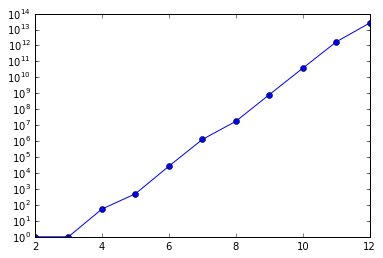

In [29]:
def plot_pairs(Ns):
    "Given a list of N values, plot the number of pairs and return a dict of them."
    Ds = [len(all_dice(N)) for N in Ns]
    Npairs = [D * (D + 1) // 2 for D in Ds]
    logplot(Ns, Npairs, 'bo-')
    return {Ns[i]: Npairs[i] for i in range(len(Ns))}

plot_pairs(ints(2, 12))

OK, we've learned two things. One, it *is* roughly a straight line, so the number of pairs is roughly exponential. Two, there are a *lot* of pairs. 10<sup>14</sup>, just for *N*=12. I don't want to even think about *N*=20.

**So if we want to get much beyond *N*=8, we're either going to need a brand new approach, or we need to make far fewer pairs of dice.**



# Making Fewer `pairs`

Maybe we could tighten up the upper bounds, but I don't think that will help very much.
How about if we concentrate on making fewer pairs, without worrying about making fewer dice?

**How could we do that? Isn't the number of pairs always (*D*<sup>2</sup> + *D*)/2 ?**

Remember, we're looking for *feasible* pairs. So if there was some way of knowing ahead of time that two dice were incompatible as a pair, we wouldn't even need to consider the pair.

**By incompatible, you mean they can't form a pair that is a solution.**

Right. Consider this: in any valid pair, the sum of the biggest number on each die must be 2*N*.  For example, with *N* = 6:

    ((1, 2, 2, 3, 3, 4), (1, 3, 4, 5, 6, 8))    sum of biggests = 4 + 8 = 12
    ((1, 2, 3, 4, 5, 6), (1, 2, 3, 4, 5, 6))    sum of biggests = 6 + 6 = 12
    
So if we have a die with biggest number 7, what dice should we consider pairing it with?

**Only ones with biggest number 5.**

**I get it: we sort all the die into bins labeled with their biggest number.  Then we look at each bin, and for the "7" bin, we pair them up with the dice in the "5" bin. In general, the *B* bin can only pair with the 2*N* - *B* bin.**

Exactly. 

**Cool. I can see how that can cut the amount of work by a factor of 10 or so. But  I was hoping for a factor of a million or so.**

There are other properties of a feasible pair.

**Like what?**

Well, what about the number of 2s in a pair?

**Let's see.  We know that any `regular_sums` has to have two 3s, and the only way to make a 3 is 2+1.  And each die has only one 1, so that means that each pair of dice has to have a total of exactly two 2s.**

Does it have to be one 2 on each die?

**No.  It could be one each, or it could be two on one die and none on the other. So a die with *T* twos can only pair with dice that have 2 - *T* twos.**

Great.  Can you think of another property?

**Give me a hint.**

Let's look at the sums of 6-sided Sicherman and regular pairs:

In [30]:
sum((1, 2, 2, 3, 3, 4) + (1, 3, 4, 5, 6, 8))

42

In [31]:
sum((1, 2, 3, 4, 5, 6) + (1, 2, 3, 4, 5, 6))

42

**They're the same. Is that [the question](http://hitchhikers.wikia.com/wiki/42) that 42 is the answer to? But does a Sicherman pair always have to have the same sum as a regular pair? I guess it doea, because the sum of `sums(pair)` is just all the sides added up *N* times each, so two pairs have the same sum of `sums(pair)` if and only if they have the same sum.**

So consider the die (1, 3, 3, 3, 4, 5). What do we know about the dice that it can possibly pair with?

**OK, that die has a biggest side of 5, so it can only pair with dice that have a biggest side of 12 - 5 = 7. It has a sum of 19, so it can only pair with dice that have a sum of 42 - 19 = 23. And it has no 2s, so it can only pair with dice that have two 2s.**

I wonder how many such dice there are, out of all 231 `all_dice(6)`?

In [32]:
{die for die in all_dice(6) if max(die) == 12 - 5 and sum(die) == 42 - 19 and die.count(2) == 2}

{(1, 2, 2, 5, 6, 7)}

**There's only 1. So, (1, 3, 3, 3, 4, 5) only has to try to pair with one die, rather than 230. Nice improvement!**

In general, I wonder what the sum of the sides of a regular pair is?

**Easy, that's `N * (N + 1)`. [Gauss](http://betterexplained.com/articles/techniques-for-adding-the-numbers-1-to-100/) knew that when he was in elementary school!**

# More efficient `pairs(dice)`

**OK, we can code this up easily enough**:

In [33]:
from collections import defaultdict

def tabulate(dice):
    """Put all dice into bins in a hash table, keyed by bin_label(die).
    Each bin holds a list of dice with that key."""
    # Example: {(21, 6, 1): [(1, 2, 3, 4, 5, 6), (1, 2, 3, 4, 4, 7), ...]
    table = defaultdict(list)
    for die in dice:
        table[bin_label(die)].append(die)
    return table

def pairs(dice):
    "Return all pairs of dice that could possibly be a solution to the Sicherman problem."
    table = tabulate(dice)
    N = len(dice[0])
    for bin1 in table:
        bin2 = compatible_bin(bin1, N)
        if bin2 in table and bin1 <= bin2:
            for A in table[bin1]:
                for B in table[bin2]:
                    yield (A, B)

def bin_label(die): return sum(die), max(die), die.count(2)

def compatible_bin(bin1, N): 
    "Return a bin label that is compatible with bin1."
    (S1, M1, T1) = bin1
    return (N * (N + 1) - S1, 2 * N - M1, 2 - T1)

**Let's make sure it works:**

In [34]:
{N: sicherman(N)
 for N in ints(2, 6)}

{2: set(),
 3: set(),
 4: {((1, 2, 2, 3), (1, 3, 3, 5))},
 5: set(),
 6: {((1, 2, 2, 3, 3, 4), (1, 3, 4, 5, 6, 8))}}

Good, those are the same answers as before. But how much faster is it?

In [35]:
%time sicherman(7)

CPU times: user 24.9 ms, sys: 1.23 ms, total: 26.1 ms
Wall time: 153 ms


set()

Wow, that's 1000 times faster than before.

**I want to take a peek at what some of the bins look like:**

In [36]:
tabulate(all_dice(5))

defaultdict(list,
            {(12, 4, 2): [(1, 2, 2, 3, 4)],
             (13, 4, 1): [(1, 2, 3, 3, 4)],
             (13, 5, 2): [(1, 2, 2, 3, 5)],
             (14, 4, 0): [(1, 3, 3, 3, 4)],
             (14, 5, 1): [(1, 2, 3, 3, 5)],
             (14, 5, 2): [(1, 2, 2, 4, 5)],
             (14, 6, 2): [(1, 2, 2, 3, 6)],
             (15, 5, 0): [(1, 3, 3, 3, 5)],
             (15, 5, 1): [(1, 2, 3, 4, 5)],
             (15, 6, 1): [(1, 2, 3, 3, 6)],
             (15, 6, 2): [(1, 2, 2, 4, 6)],
             (16, 5, 0): [(1, 3, 3, 4, 5)],
             (16, 5, 1): [(1, 2, 4, 4, 5)],
             (16, 6, 0): [(1, 3, 3, 3, 6)],
             (16, 6, 1): [(1, 2, 3, 4, 6)],
             (16, 6, 2): [(1, 2, 2, 5, 6)],
             (17, 5, 0): [(1, 3, 4, 4, 5)],
             (17, 6, 0): [(1, 3, 3, 4, 6)],
             (17, 6, 1): [(1, 2, 3, 5, 6), (1, 2, 4, 4, 6)],
             (18, 5, 0): [(1, 4, 4, 4, 5)],
             (18, 6, 0): [(1, 3, 3, 5, 6), (1, 3, 4, 4, 6)],
             (18, 6, 1):

**Pretty good: four of the bins have two dice, but the rest have only one die.**

And let's see how many pairs we're producing now.  We'll tabulate *N* (the number of sides); *D* (the number of *N*-sided dice), the number `pairs(dice)` using the new `pairs`, and the number using the old `pairs`:

In [37]:
print(' N:         D #pairs(dice)         D*(D-1)/2')
for N in ints(2, 11):
    dice = list(all_dice(N))
    D = len(dice)
    print('{:2}: {:9,d} {:12,d} {:17,d}'.format(N, D, len(list(pairs(dice))), D*(D-1)//2))

 N:         D #pairs(dice)         D*(D-1)/2
 2:         1            1                 0
 3:         1            1                 0
 4:        10            3                45
 5:        31            9               465
 6:       231           71            26,565
 7:     1,596          670         1,272,810
 8:     5,916        6,614        17,496,570
 9:    40,590       76,215       823,753,755
10:   274,274      920,518    37,612,976,401
11: 1,837,836   11,506,826 1,688,819,662,530


OK, we're doing 100,000 times better for *N*=11. But it would still take a long time to test 11 million pairs. Let's just get the answers up to *N*=10:

In [38]:
%%time
{N: sicherman(N)
 for N in ints(2, 10)}

CPU times: user 26.2 s, sys: 129 ms, total: 26.3 s
Wall time: 26.6 s


{2: set(),
 3: set(),
 4: {((1, 2, 2, 3), (1, 3, 3, 5))},
 5: set(),
 6: {((1, 2, 2, 3, 3, 4), (1, 3, 4, 5, 6, 8))},
 7: set(),
 8: {((1, 2, 2, 3, 3, 4, 4, 5), (1, 3, 5, 5, 7, 7, 9, 11)),
  ((1, 2, 2, 3, 5, 6, 6, 7), (1, 3, 3, 5, 5, 7, 7, 9)),
  ((1, 2, 3, 3, 4, 4, 5, 6), (1, 2, 5, 5, 6, 6, 9, 10))},
 9: {((1, 2, 2, 3, 3, 3, 4, 4, 5), (1, 4, 4, 7, 7, 7, 10, 10, 13))},
 10: {((1, 2, 2, 3, 3, 4, 4, 5, 5, 6), (1, 3, 5, 6, 7, 8, 9, 10, 12, 14))}}

Not bad; we solved it for all *N* up to 10 in just a few seconds more than it took for just *N*=7 with the old version. Interestingly, there are solutions for all composite *N* but no prime *N*. So I have some questions:

- Do all composire *N* have solutions?
- Do no prime *N* have solutions?
- Do some *N* have more than the 3 solutions that 8 has?
- Could we handle larger *N* if we worked with [generating functions](https://en.wikipedia.org/wiki/Sicherman_dice)?


**Good questions, but I think this is a good place to stop for now.**

Agreed!